# Predict Income in the Census Income Dataset

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scipy.stats as stats
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages

## Part 1: Build DataFrame

#### Load a Data Set and Save it as a Pandas DataFrame

In [2]:
adultDataSet_filename = os.path.join(os.getcwd(), "data", "censusData.csv")

df = pd.read_csv(adultDataSet_filename)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex_selfID,capital-gain,capital-loss,hours-per-week,native-country,income_binary
0,39.0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Non-Female,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Non-Female,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Non-Female,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Non-Female,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K


## Part 2: Define ML Problem


This is a supervised learning problem (binary classification).

Being able to predict income level is valuable in various business and policy-making contexts:

Targeted Marketing: Companies can use income predictions to tailor advertising or recommend relevant products/services (e.g., premium offerings vs. budget options).

Credit Risk Assessment: Financial institutions can assess whether a person is likely to meet financial obligations, helping in loan approval or credit card offerings.

## Part 3: Understand Data

The next step is to perform exploratory data analysis.

In [3]:
df.shape

(32561, 15)

In [4]:
df = df.drop(columns=['education', 'relationship', 'fnlwgt', 'native-country'])
# drop education as education_num already captures it. relationship doesn't seem that relevant, race already captures native-country,
# drop fnlwgt as it's a random weight assigned to rows and has no predictive value

## Visualizing Data and Detect Outliers

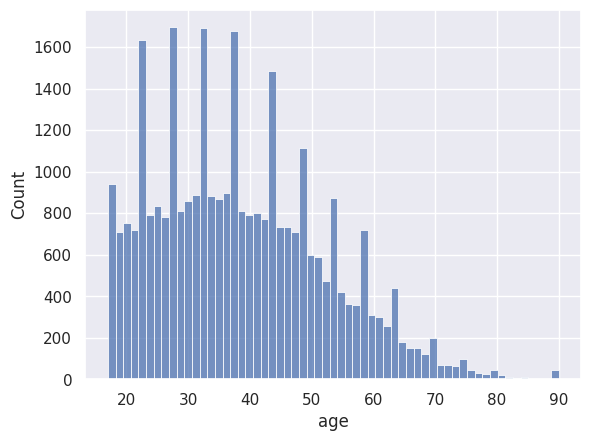

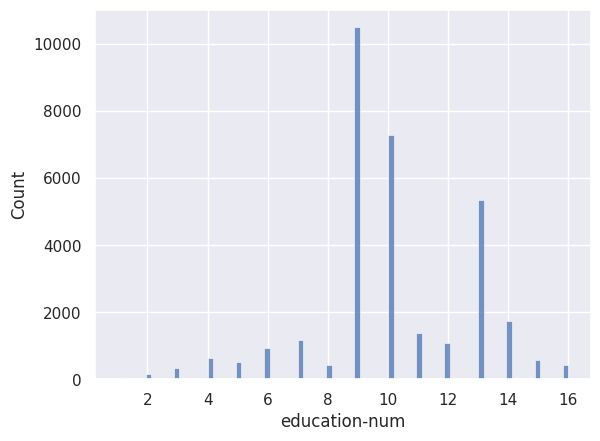

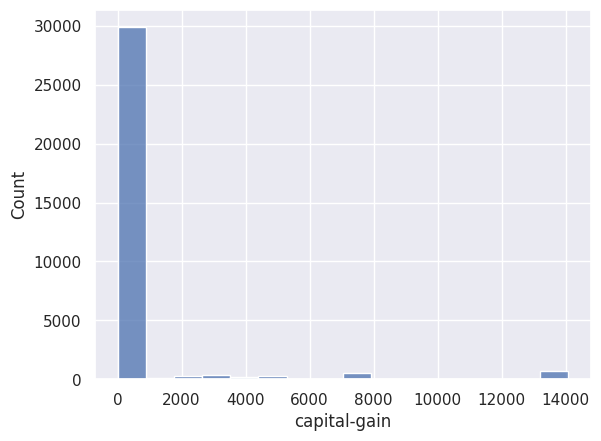

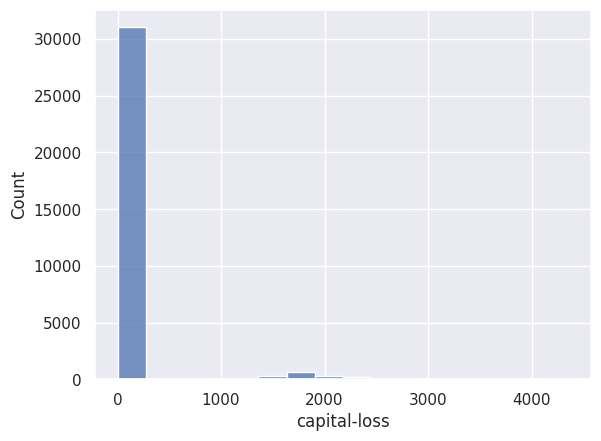

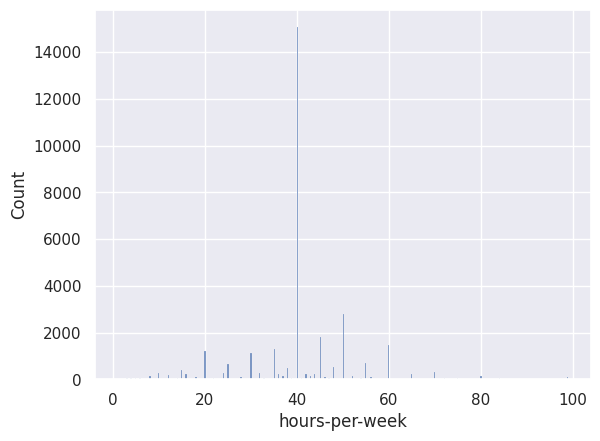

In [5]:
numerical_cols = df.select_dtypes(exclude=['object']).columns

for col in numerical_cols:
    plt.figure()
    sns.histplot(data=df, x=col)

In [6]:
df.describe(include='all')

,age,workclass,education-num,marital-status,occupation,race,sex_selfID,capital-gain,capital-loss,hours-per-week,income_binary
count,32399.000000,30725,32561.000000,32561,30718,32561,32561,32561.000000,32561.000000,32236.000000,32561
unique,NaN,8,NaN,7,14,5,2,NaN,NaN,NaN,2
top,NaN,Private,NaN,Married-civ-spouse,Prof-specialty,White,Non-Female,NaN,NaN,NaN,<=50K
freq,NaN,22696,NaN,14976,4140,27816,21790,NaN,NaN,NaN,24720
mean,38.589216,NaN,10.080679,NaN,NaN,NaN,NaN,615.907773,87.303830,40.450428,NaN
std,13.647862,NaN,2.572720,NaN,NaN,NaN,NaN,2420.191974,402.960219,12.353748,NaN
min,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN
25%,28.000000,NaN,9.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN
50%,37.000000,NaN,10.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN
75%,48.000000,NaN,12.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN


In [7]:
df.dtypes

age               float64
workclass          object
education-num       int64
marital-status     object
occupation         object
race               object
sex_selfID         object
capital-gain        int64
capital-loss        int64
hours-per-week    float64
income_binary      object
dtype: object

Out of all these, looking at the summary stats, capital-gain, capital-loss and hours per week seem to have outliers as they have high standard deviation and their max is more than 3 standard deviations away from the mean. We will winsorize these.

In [8]:
df['capital-gain-win'] = stats.mstats.winsorize(df['capital-gain'], limits=[0.01, 0.01])
df['capital-loss-win'] = stats.mstats.winsorize(df['capital-loss'], limits=[0.01, 0.01])
df['hours-per-week-win'] = stats.mstats.winsorize(df['hours-per-week'], limits=[0.01, 0.01])
df = df.drop(columns=['capital-gain', 'capital-loss', 'hours-per-week'])
df.head()

,age,workclass,education-num,marital-status,occupation,race,sex_selfID,income_binary,capital-gain-win,capital-loss-win,hours-per-week-win
0,39.0,State-gov,13,Never-married,Adm-clerical,White,Non-Female,<=50K,2174,0,40.0
1,50.0,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,White,Non-Female,<=50K,0,0,13.0
2,38.0,Private,9,Divorced,Handlers-cleaners,White,Non-Female,<=50K,0,0,40.0
3,53.0,Private,7,Married-civ-spouse,Handlers-cleaners,Black,Non-Female,<=50K,0,0,40.0
4,28.0,Private,13,Married-civ-spouse,Prof-specialty,Black,Female,<=50K,0,0,40.0


## Handling Missing Data

In [9]:
nan_count = np.sum(df.isnull(), axis = 0)
nan_count

age                    162
workclass             1836
education-num            0
marital-status           0
occupation            1843
race                     0
sex_selfID               0
income_binary            0
capital-gain-win         0
capital-loss-win         0
hours-per-week-win       0
dtype: int64

Out of the columns with missing values, age and hours-per-week have numeric values, we can replace unknown values with mean

In [10]:
mean_age=df['age'].mean()
df['age'].fillna(value=mean_age, inplace=True)

df['workclass'].fillna(value='Unknown', inplace=True)
df['occupation'].fillna(value='Unknown', inplace=True)

df.isnull().values.any()

False

## Consolidating Groups

In [11]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Unknown', 'Self-emp-inc', 'Without-pay',
       'Never-worked'], dtype=object)

Consolidating all of the different types of employment into two groups: **self-employed** and **not self-employed**, and changing the values in the `workclass` column accordingly.

In [12]:
# Since there are only two values for self-employment, we can simplify our code by mapping 
# 0 as not self employed and 1 as self employed

columns_not_self_employed = ~(df['workclass'] == 'Self-emp-not-inc') & ~(df['workclass'] == 'Self-emp-inc') 

condition = columns_not_self_employed
df['workclass'] = np.where(condition, 'not-self-employed', df['workclass'])
condition = ~(df['workclass'] == 'not-self-employed')
df['workclass'] = np.where(condition, 'self-employed', df['workclass'])
df['workclass'] = df['workclass'].map({'not-self-employed': 0,'self-employed': 1})

df.rename(columns={'workclass': 'self_employed'}, inplace=True)

In [13]:
df['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

Consolidating all of the different types of marital-status into two groups: **married** and **single**, and changing the values in the `marital-status` column accordingly.

In [14]:
condition = (df['marital-status'] == 'Married-civ-spouse') | (df['marital-status'] == 'Married-AF-spouse')
df['marital-status'] = np.where(condition, 'married', df['marital-status'])

condition = ~(df['marital-status'] == 'married')
df['marital-status'] = np.where(condition, 'single', df['marital-status'])

df['marital-status'] = df['marital-status'].map({'single': 0, 'married': 1})
df = df.rename(columns={'marital-status': 'married'})

Consolidating all of the different types of race into two groups: **White** and **minority**, and changing the values in the `race` column accordingly.

In [15]:
df['race'].value_counts()

condition = ~(df['race'] == 'White')
df['race'] = np.where(condition, 'Minority', df['race'])

df['race'] = df['race'].map({'White': 0, 'Minority': 1})
df = df.rename(columns={'race': 'minority_race'})

In [16]:
df['sex_selfID'] = df['sex_selfID'].map({'Non-Female': 0, 'Female': 1})
df = df.rename(columns={'sex_selfID': 'female'})

In [17]:
df['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Unknown              1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

In [18]:
# need to group
condition = (df['occupation'] == 'Prof-specialty') | (df['occupation'] == 'Exec-managerial') | (df['occupation'] == 'Tech-support')
df['occupation'] = np.where(condition, 'Management', df['occupation'])

condition = (df['occupation'] == 'Craft-repair') | (df['occupation'] == 'Machine-op-inspct') | (df['occupation'] == 'Transport-moving') \
            | (df['occupation'] == 'Farming-fishing') | (df['occupation'] == 'Handlers-cleaners')

df['occupation'] = np.where(condition, 'Skilled', df['occupation'])

condition = (df['occupation'] == 'Adm-clerical') | (df['occupation'] == 'Sales')

df['occupation'] = np.where(condition, 'Support', df['occupation'])

condition = (df['occupation'] == 'Other-service') | (df['occupation'] == 'Protective-serv') | (df['occupation'] == 'Priv-house-serv') \
            | (df['occupation'] == 'Armed-Forces')

df['occupation'] = np.where(condition, 'Service', df['occupation'])

df['occupation'].value_counts()

Skilled       10062
Management     9134
Support        7420
Service        4102
Unknown        1843
Name: occupation, dtype: int64

In [19]:
# target label
df['income_binary'] = df['income_binary'].map({'<=50K': 0, '>50K': 1}).astype(int)

In [20]:
df.dtypes

age                   float64
self_employed           int64
education-num           int64
married                 int64
occupation             object
minority_race           int64
female                  int64
income_binary           int64
capital-gain-win        int64
capital-loss-win        int64
hours-per-week-win    float64
dtype: object

## One Hot Encoding

In [21]:
to_encode = list(df.select_dtypes(include='object'))

In [22]:
df[to_encode].nunique()

occupation    5
dtype: int64

In [23]:
for col in to_encode:
    dummy = pd.get_dummies(df[col], prefix=col)
    df = df.join(dummy)

df.drop(columns=to_encode, inplace=True)
df.head()

,age,self_employed,education-num,married,minority_race,female,income_binary,capital-gain-win,capital-loss-win,hours-per-week-win,occupation_Management,occupation_Service,occupation_Skilled,occupation_Support,occupation_Unknown
0,39.0,0,13,0,0,0,0,2174,0,40.0,0,0,0,1,0
1,50.0,1,13,1,0,0,0,0,0,13.0,1,0,0,0,0
2,38.0,0,9,0,0,0,0,0,0,40.0,0,0,1,0,0
3,53.0,0,7,1,1,0,0,0,0,40.0,0,0,1,0,0
4,28.0,0,13,1,1,1,0,0,0,40.0,1,0,0,0,0


In [24]:
df.columns

Index(['age', 'self_employed', 'education-num', 'married', 'minority_race',
       'female', 'income_binary', 'capital-gain-win', 'capital-loss-win',
       'hours-per-week-win', 'occupation_Management', 'occupation_Service',
       'occupation_Skilled', 'occupation_Support', 'occupation_Unknown'],
      dtype='object')

In [25]:
print(df.dtypes)

age                      float64
self_employed              int64
education-num              int64
married                    int64
minority_race              int64
female                     int64
income_binary              int64
capital-gain-win           int64
capital-loss-win           int64
hours-per-week-win       float64
occupation_Management      uint8
occupation_Service         uint8
occupation_Skilled         uint8
occupation_Support         uint8
occupation_Unknown         uint8
dtype: object


## Part 4: Define Project Plan

The different data preparation techniques I used were replacing outliers, replacing missing values, and consolidating different groups.
I plan to iterate different models (KNN, Decision Trees, LR, Ensemble Methods) and choose the best one while considering accuracy, precision, and recall.
I also plan to inspect if there are any minority groups that are underrepresented so I can upsample them.

## Part 5: Implement Project Plan

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Account For Bias

In [27]:
X = df.drop(columns='income_binary')
y = df['income_binary']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

In [29]:
df['income_binary'].value_counts(normalize=True)

0    0.75919
1    0.24081
Name: income_binary, dtype: float64

In [30]:
train_df = pd.concat([X_train, y_train], axis=1)

In [31]:
majority_class = train_df[train_df['income_binary'] == 0]
minority_class = train_df[train_df['income_binary'] == 1]

In [32]:
minority_upsampled = minority_class.sample(n=len(minority_class), replace=True, random_state=1234)

In [33]:
train_balanced = pd.concat([majority_class, minority_upsampled])

In [34]:
X_train_balanced = train_balanced.drop('income_binary', axis=1)
y_train_balanced = train_balanced['income_binary']

In [35]:
train_balanced['income_binary'].value_counts(normalize=True)

0    0.75733
1    0.24267
Name: income_binary, dtype: float64

In [36]:
train_balanced.shape

(24420, 15)

In [37]:
print(train_balanced.groupby('female')['income_binary'].value_counts(normalize=True))

print(train_balanced.groupby('minority_race')['income_binary'].value_counts(normalize=True))

female  income_binary
0       0                0.691923
        1                0.308077
1       0                0.890561
        1                0.109439
Name: income_binary, dtype: float64
minority_race  income_binary
0              0                0.742291
               1                0.257709
1              0                0.846154
               1                0.153846
Name: income_binary, dtype: float64


Percentage of women earning above 50K is ~10% while the percentage of men earning above 50K is ~30%.
Similarly, percentage of people belonging to minority races earning above 50K is ~15% while percentage of whites earning above 50K is ~25%.

We can clearly see there is an imbalance in our training set, and the model might get biased towards favoring a certain gender/ race. 

Hence, we will upsample.

In [38]:
female_high_income = train_balanced[(train_balanced['female'] == 1) & (train_balanced['income_binary'] == 1)]
male_high_income = train_balanced[(train_balanced['female'] == 0) & (train_balanced['income_binary'] == 1)]

minority_high_income = train_balanced[(train_balanced['minority_race'] == 1) & (train_balanced['income_binary'] == 1)]
white_high_income = train_balanced[(train_balanced['minority_race'] == 0) & (train_balanced['income_binary'] == 1)]


target_size_female = len(male_high_income) - len(female_high_income)
target_size_minority = len(white_high_income) - len(minority_high_income)

female_high_income_upsampled = female_high_income.sample(n=target_size_female, replace=True, random_state=42)
minority_high_income_upsampled = minority_high_income.sample(n=target_size_minority, replace=True, random_state=42)

train_balanced = pd.concat([train_balanced, female_high_income_upsampled, minority_high_income_upsampled], ignore_index=True)

In [39]:
print(train_balanced.groupby('female')['income_binary'].value_counts())

print(train_balanced.groupby('minority_race')['income_binary'].value_counts())

print(train_balanced['income_binary'].value_counts(normalize=True))

female  income_binary
0       0                11333
        1                 8639
1       0                 7161
        1                 6291
Name: income_binary, dtype: int64
minority_race  income_binary
0              0                15502
               1                 8894
1              1                 6036
               0                 2992
Name: income_binary, dtype: int64
0    0.553315
1    0.446685
Name: income_binary, dtype: float64


In [40]:
train_balanced.shape

(33424, 15)

In [41]:
X_train = train_balanced.drop(columns='income_binary')
y_train = train_balanced['income_binary']

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(33424, 14) (8141, 14) (33424,) (8141,)


## Model Selection

### a. Train, Test and Evaluate a Logistic Regression

In [43]:
param_grid = {'C': [10**i for i in range(-10,10)]}

In [44]:
print('Running Grid Search...')

lr_model = LogisticRegression(max_iter=10000)
lr_grid = GridSearchCV(lr_model, param_grid, cv=3, scoring='accuracy')
lr_grid_search = lr_grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [45]:
acc_lr = lr_grid_search.best_score_
print("[KNN] Accuracy Score for the best model is : {:.2f}".format(acc_lr))

[KNN] Accuracy Score for the best model is : 0.76


In [46]:
lr_best_params = lr_grid_search.best_params_
lr_best_params

{'C': 0.01}

In [47]:
lr_model = LogisticRegression(C=lr_best_params['C'], max_iter=10000)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=10000)

In [48]:
y_lr_pred = lr_model.predict(X_test)

lr_acc_score = accuracy_score(y_test, y_lr_pred)
lr_prec_score = precision_score(y_test, y_lr_pred)
lr_recall_score = recall_score(y_test, y_lr_pred)
print('[LR] Accuracy Score: {0}'.format(lr_acc_score))
print('[LR] Precision Score: {0}'.format(lr_prec_score))
print('[LR] Recall Score: {0}'.format(lr_recall_score))

[LR] Accuracy Score: 0.8086230192851002
[LR] Precision Score: 0.5793686082703424
[LR] Recall Score: 0.6804177545691906


### b. Train, Test and Evaluate KNN Using GridSearch

In [49]:
param_grid = {'n_neighbors': [2,3,4,5]}

In [50]:
print('Running Grid Search...')

knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_model, param_grid, cv=3, scoring='accuracy')
knn_grid_search = knn_grid.fit(X_train, y_train)

print('Done')

Running Grid Search...
Done


In [51]:
acc_knn = knn_grid_search.best_score_
print("[KNN] Accuracy Score for the best model is : {:.2f}".format(acc_knn))

[KNN] Accuracy Score for the best model is : 0.84


In [52]:
knn_best_params = knn_grid_search.best_params_
knn_best_params

{'n_neighbors': 3}

In [53]:
knn_model = KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors'])
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [54]:
y_knn_pred = knn_model.predict(X_test)

knn_acc_score = accuracy_score(y_test, y_knn_pred)
knn_prec_score = precision_score(y_test, y_knn_pred)
knn_recall_score = recall_score(y_test, y_knn_pred)

print('[KNN] Accuracy Score: {0}'.format(knn_acc_score))
print('[KNN] Precision Score: {0}'.format(knn_prec_score))
print('[KNN] Recall Score: {0}'.format(knn_recall_score))

[KNN] Accuracy Score: 0.8229947180936003
[KNN] Precision Score: 0.6737536656891495
[KNN] Recall Score: 0.47989556135770234


### c. Train, Test and Evaluate a Decision Tree Using GridSearch

In [55]:
param_grid = {'max_depth': [30, 35, 40, 45, 50], 'min_samples_leaf': [1, 2, 3, 4, 5]}

In [56]:
print('Running Grid Search...')

dt_model = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_model, param_grid, cv=3, scoring='accuracy')
dt_grid_search = dt_grid.fit(X_train, y_train)

print('Done')


Running Grid Search...
Done


In [57]:
acc_dt = dt_grid_search.best_score_
print("[DT] Accuracy Score for the best model is : {:.2f}".format(acc_dt))

[DT] Accuracy Score for the best model is : 0.86


In [58]:
dt_best_params = dt_grid_search.best_params_
dt_best_params

{'max_depth': 40, 'min_samples_leaf': 1}

In [59]:
dt_model = DecisionTreeClassifier(max_depth=dt_best_params['max_depth'], min_samples_leaf=dt_best_params['min_samples_leaf'])
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=40)

In [60]:
y_dt_pred = dt_model.predict(X_test)

dt_acc_score = accuracy_score(y_test, y_dt_pred)
dt_prec_score = precision_score(y_test, y_dt_pred)
dt_recall_score = recall_score(y_test, y_dt_pred)

print('[DT] Accuracy Score: {0}'.format(dt_acc_score))
print('[DT] Precision Score: {0}'.format(dt_prec_score))
print('[DT] Recall Score: {0}'.format(dt_recall_score))

[DT] Accuracy Score: 0.8120624001965361
[DT] Precision Score: 0.6153385260635111
[DT] Recall Score: 0.5362924281984334


### d. Train, Test and Evaluate Ensemble Models: Stacking 

In [61]:
estimators = [("DT", DecisionTreeClassifier(max_depth=dt_best_params['max_depth'], min_samples_leaf=dt_best_params['min_samples_leaf'])),
              ("LR", LogisticRegression(max_iter=10000, C=lr_best_params['C'])), 
              ("KNN", KNeighborsClassifier(n_neighbors=knn_best_params['n_neighbors']))
             ]

In [62]:
print('Implement Stacking...')

stacking_model = StackingClassifier(estimators=estimators, passthrough=False)
stacking_model.fit(X_train, y_train)

print('End')

Implement Stacking...
End


In [63]:
y_stacking_pred = stacking_model.predict(X_test)

stacking_acc_score = accuracy_score(y_test, y_stacking_pred)
stacking_prec_score = precision_score(y_test, y_stacking_pred)
stacking_recall_score = recall_score(y_test, y_stacking_pred)

print('[Stacking] Accuracy Score: {0}'.format(stacking_acc_score))
print('[Stacking] Precision Score: {0}'.format(stacking_prec_score))
print('[Stacking] Recall Score: {0}'.format(stacking_recall_score))

[Stacking] Accuracy Score: 0.833681365925562
[Stacking] Precision Score: 0.6774193548387096
[Stacking] Recall Score: 0.5592689295039165


### e. Train, Test and Evaluate  Evaluate Ensemble Models: Gradient Boosted Decision Trees 

In [64]:
param_grid = {
    'n_estimators': [260, 270, 280],
    'max_depth': [5, 10, 15]
}

In [65]:
print('Implement GBDT...')


gbdt_model = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gbdt_grid_search = gbdt_grid.fit(X_train, y_train)

print('End')

Implement GBDT...
End


In [66]:
acc_gbdt = gbdt_grid_search.best_score_
print("[GBDT] Accuracy for the best model is : {:.2f}".format(acc_gbdt))

[GBDT] Accuracy for the best model is : 0.88


In [67]:
gbdt_best_params = gbdt_grid_search.best_params_
gbdt_best_params

{'max_depth': 10, 'n_estimators': 270}

In [68]:
print('Begin GBDT Implementation...')

gbdt_model = GradientBoostingClassifier(max_depth=gbdt_best_params['max_depth'], n_estimators=gbdt_best_params['n_estimators'])
gbdt_model.fit(X_train, y_train)

print('End')

Begin GBDT Implementation...
End


In [69]:
y_gbdt_pred = gbdt_model.predict(X_test)

gbdt_acc_score = accuracy_score(y_test, y_gbdt_pred)
gbdt_prec_score = precision_score(y_test, y_gbdt_pred)
gbdt_recall_score = recall_score(y_test, y_gbdt_pred)

print('[GBDT] Accuracy Score: {0}'.format(gbdt_acc_score))
print('[GBDT] Precision Score: {0}'.format(gbdt_prec_score))
print('[GBDT] Recall Score: {0}'.format(gbdt_recall_score))

[GBDT] Accuracy Score: 0.836752241739344
[GBDT] Precision Score: 0.6801968019680197
[GBDT] Recall Score: 0.5775456919060052


### f. Train, Test and Evaluate  Ensemble Models: Random Forest

In [70]:
param_grid = {
    'n_estimators': [70, 80, 90, 100, 200],
    'max_depth': [5, 10, 20, 30, 35, 40]
}

In [71]:
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy')
rf_grid_search = rf_grid.fit(X_train, y_train)

In [72]:
acc_rf = rf_grid_search.best_score_
print("[RF] accuracy for the best model is : {:.2f}".format(acc_rf) )

[RF] accuracy for the best model is : 0.87


In [73]:
rf_best_params = rf_grid_search.best_params_
rf_best_params

{'max_depth': 35, 'n_estimators': 100}

In [74]:
print('Begin RF Implementation...')

rf_model = RandomForestClassifier(max_depth=rf_best_params['max_depth'], n_estimators=rf_best_params['n_estimators'])
rf_model.fit(X_train, y_train)

print('End')

Begin RF Implementation...
End


In [75]:
y_rf_pred = rf_model.predict(X_test)

rf_acc_score = accuracy_score(y_test, y_rf_pred)
rf_prec_score = precision_score(y_test, y_rf_pred)
rf_recall_score = recall_score(y_test, y_rf_pred)

print('[RF] Accuracy Score: {0}'.format(rf_acc_score))
print('[RF] Precision Score: {0}'.format(rf_prec_score))
print('[RF] Recall Score: {0}'.format(rf_recall_score))

[RF] Accuracy Score: 0.8298734799164722
[RF] Precision Score: 0.6650062266500623
[RF] Recall Score: 0.5577023498694517


### g. Visualize and Compare Model Performance

[0.833681365925562, 0.8086230192851002, 0.8120624001965361, 0.836752241739344, 0.8298734799164722, 0.8229947180936003]


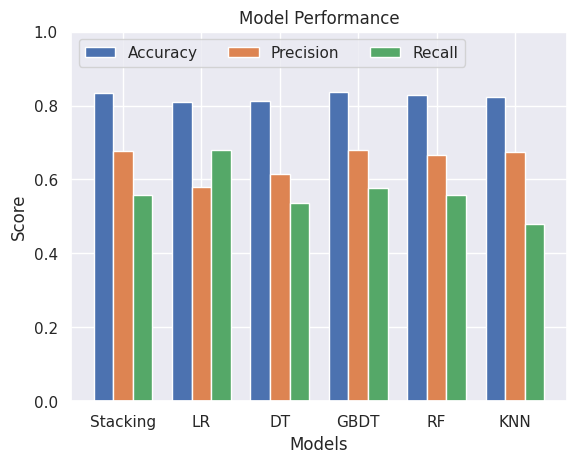

In [76]:
Accuracy_Results = [stacking_acc_score, lr_acc_score, dt_acc_score, gbdt_acc_score, rf_acc_score, knn_acc_score]
Precision_Results = [stacking_prec_score, lr_prec_score, dt_prec_score, gbdt_prec_score, rf_prec_score, knn_prec_score]
Recall_Results = [stacking_recall_score, lr_recall_score, dt_recall_score, gbdt_recall_score, rf_recall_score, knn_recall_score]
print(Accuracy_Results)
rg= np.arange(6)
width = 0.25

plt.bar(rg - width, Accuracy_Results, width, label='Accuracy')
plt.bar(rg, Precision_Results, width, label='Precision')
plt.bar(rg + width, Recall_Results, width, label='Recall')

labels = ['Stacking', 'LR', 'DT', 'GBDT', 'RF', 'KNN']
plt.xticks(rg, labels)
plt.xlabel("Models")
plt.ylabel("Score")

plt.ylim([0,1])
plt.title('Model Performance')
plt.legend(loc='upper left', ncol=3)
plt.show()

I chose to work with GBDT as I want to prioritize accuracy, but also consider precision and recall. 

In [77]:
from sklearn.metrics import confusion_matrix
X_test_copy = X_test.copy()
X_test_copy['actual'] = y_test
X_test_copy['predicted'] = gbdt_model.predict(X_test)

def print_conf_matrix_for_group(df, group_col, group_val, group_name):
    group = df[df[group_col] == group_val]
    y_true = group['actual']
    y_pred = group['predicted']
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print(f"\nConfusion Matrix for {group_name}:")
    print("                Predicted 0    Predicted 1")
    print(f"Actual 0     {cm[0][0]:>10}    {cm[0][1]:>10}")
    print(f"Actual 1     {cm[1][0]:>10}    {cm[1][1]:>10}")

print_conf_matrix_for_group(X_test_copy, 'female', 1, "Females")
print_conf_matrix_for_group(X_test_copy, 'female', 0, "Males")
print_conf_matrix_for_group(X_test_copy, 'minority_race', 1, "Minorities")
print_conf_matrix_for_group(X_test_copy, 'minority_race', 0, "Whites")



Confusion Matrix for Females:
                Predicted 0    Predicted 1
Actual 0           2331           100
Actual 1            147           179

Confusion Matrix for Males:
                Predicted 0    Predicted 1
Actual 0           3375           420
Actual 1            662           927

Confusion Matrix for Minorities:
                Predicted 0    Predicted 1
Actual 0            948            81
Actual 1             78           106

Confusion Matrix for Whites:
                Predicted 0    Predicted 1
Actual 0           4758           439
Actual 1            731          1000


From the confusion matrix, we can see that our model does not bias against any specific group.